<a href="https://colab.research.google.com/github/TYH71/DELE_CA1/blob/main/Part%20A/3.1%20Modified_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST - Modified VGG16


- Name: Tan Yu Hoe
- Admin No: P2026309
- Class: DAAA/FT/2B/04

## Motivation

This notebook is purposed to train and evaluate a Convolution Neural Network on Fashion MNIST dataset, implementing a modified version of the VGG16 architecture. The idea is to edit the architecture such that it is dedicated to the Fashion MNIST dataset.

## Personal Objectives

These are objectives / goals for myself to accomplish while attempting to perform image classification for the Fashion MNIST dataset.

1. Obtain a high test accuracy compared to public benchmark (The average benchmark for Fashon MNIST is about 90% Test Accuracy)
2. Experiment with multiple training strategies and CNN architectures

## !! Important Note !!

As this is an experimentation run, I would not go so in depth into Exploratory Data Analysis, Feature Engineering, Augmentation and Image Processing. The markdown headers are used as checkpoints for me to better navigate around the notebook using Google Colaboratory.


In [ ]:
# import relevant libraries/classes/dependencies
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import datetime
!pip install -q pytz
import pytz
sg = pytz.timezone("Singapore")

# Set the random seeds - to ensure reproducibility
os.environ['TF_CUDNN_DETERMINISTIC'] = "1"
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [ ]:
# Matplotlib Stylings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
plt.style.use('fivethirtyeight')

## Setting up **Weights and Biases**


In [ ]:
# install and configure weights and biases
!pip install -q wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: Currently logged in as: tyh71 (use `wandb login --relogin` to force relogin)


True

## Training on a Tesla P100-PCIE-16GB


In [ ]:
!nvidia-smi

Mon Nov 22 06:46:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Checking if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7755737966861780629
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6454771826700624882
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


## Data Injestion


In [ ]:
# Import Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', "Coat", "Sandle", 'Shirt', 'Sneaker', 'Bag', 'Ankle Boots']
print('Dataset Loaded')

Dataset Loaded


In [ ]:
# Shape of Training and Testing Sets
print("X_train:", x_train.shape, "y_train:", y_train.shape)
print("X_test:", x_test.shape, "y_test:", y_test.shape)

X_train: (60000, 28, 28) y_train: (60000,)
X_test: (10000, 28, 28) y_test: (10000,)


In [ ]:
# Import Keras Functions
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.nn import local_response_normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

## Feature Engineering


In [ ]:
def preprocessing_func(x, y):
    # preprocess X
    x = x.reshape((-1, 28, 28, 1))
    x = tf.cast(x, tf.float32)
    x = tf.image.grayscale_to_rgb(x)
    x = Rescaling(1./127.5, offset=-1)(x)

    return x, y

# transform 
x_train, y_train = preprocessing_func(x_train, y_train)
x_test, y_test = preprocessing_func(x_test, y_test)

print("Training Shape:", x_train.shape, y_train.shape)
print("Testing Shape:", x_test.shape, y_test.shape)


Training Shape: (60000, 28, 28, 3) (60000,)
Testing Shape: (10000, 28, 28, 3) (10000,)


## Data Augmentation


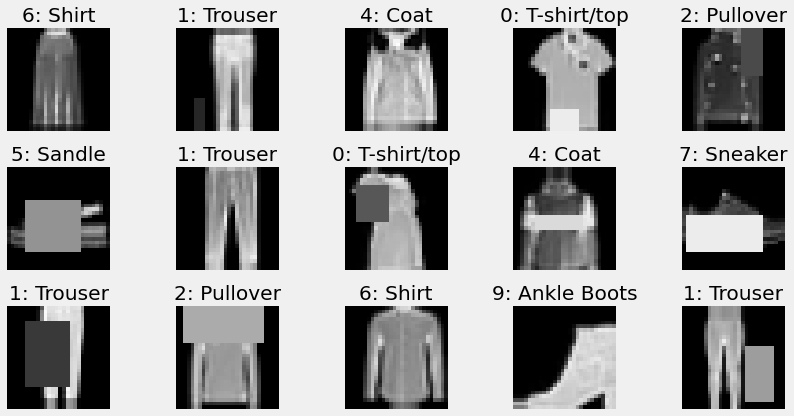

In [ ]:
## source code: https://github.com/yu4u/mixup-generator/blob/master/random_eraser.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# prepare image data generator for augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=-1, v_h=1),
    validation_split=0.1,
)

# display images from
example_ds = train_datagen.flow(x=x_train, y=y_train)
fig = plt.figure()
for i in range(15):
    img, label = example_ds.next()
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow((img[0] + 1) / 2)
    ax.set_title(f"{label[0]}: {classes[label[0]]}")
    ax.axis('off')
plt.show()

## Modified VGG16 Architecture Implementation

The runner-up in the ILSVRC 2014 challenge was VGGNet, developed by Karen Simonyan and Andrew Zisserman from the Visual Geometry Group (VGG) research lab at Oxford University. It had a very simple and classical architecture, with 2 or 3 convolutional layers and a pooling layer, then again 2 or 3 convolutional layers and a pooling layer, and so on (reaching a total of just 16 or 19 covolutional layers, depending on the VGG variant, plus a final dense network with 2 hidden layers and the output layer. [1]

One important but minor concept in VGG16, it only uses the smallest receptive filter which is $3 \times 3$ filters (smallest size to capture the notion of left/right, up/down, center) as it is able to better extract key features from the convolution process as compared to $5 \times 5$ or $7 \times 7 $ filters.

In the section header I put in the word **Modified**, in later sections I will explain why and what was modified from the original VGG16 architecture.

| ![](https://i.imgur.com/BjTt4OZ.jpeg) | 
|:--:| 
| VGG16 Architecture |

---

- [1] Karen Simonyan and Andrew Zisserman, "Very Deep Covolutional Networks for Large Scale Image Recognition" arXiv preprint [arXiv:1409.1556](https://arxiv.org/abs/1409.1556) (2014)


### Modified VGG16 Convolution Block

Actually this block isn't special or unique to only VGG16, it is fairly common to have multiple convolution layers stack directly on top of one another before spatial pooling. (eg. AlexNet) Here, I created a slight modification, I added batch normalisation after each convolution layer, to have better training and adding some regualization effect on the network. Furthermore, I also added a 2D Spatial Dropout layer to add some regularization effect to the down-sampled feature map.

|![](https://i.imgur.com/8rUfe8d.jpeg)|
|:--:|
| Illustration of Modified VGG16 Convolution Block |


In [ ]:
# VGG16 Block
def vgg16_module(neurons: int, conv_num:int, num:int, dropout=0):
    '''
    Creates a generic Hidden Conv2D Layer with ReLU Activations
    Including Batch Normalization and Max Pooling Layers
    
    Args:
        - neurons: number of neurons in the dense layer
        - conv_num: number of conv layer
        - num    : block number
        - dropout: amount of dropout regularization to be applied
    '''
    block = Sequential(name=f'Covolution_Block_{num}')

    for i in range(conv_num):
      block.add(Conv2D(neurons, kernel_size=(3, 3),
                  activation='relu', strides=1, padding='same', kernel_initializer='he_normal'))
      block.add(BatchNormalization())

    block.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
    block.add(SpatialDropout2D(dropout, data_format='channels_last'))
    
    return block

### Building a VGG Network

Unlike the VGG16 architecture, I decided to include 4 convolution blocks instead of 5. This is done such that the convolution / feature extraction process in the network will only downsample to a $2 \times 2$ feature map. Afterwards, I plan to replace the entire classification block with `Global Max Pooling` to reduce the number of parameters, following the trend of mordern day CNN architectures.

- `Sparse Categorical Cross-Entropy`

As the prediction task is a multi-class image classification task, it is pretty straightforward Categorical Cross Entropy as the specified loss function, in order to predict the probabilities of each class. I used `Sparse Categorical Cross-Entropy` as the $Y$ labels came as an integer, thus there is no need to One-Hot encode the labels.

$$ J(w) = -\frac{1}{N} \sum^N_{i=1}{[y_{i}log(\hat{y}_i) + (1 - y_i)log(1 - \hat{y}_i)]} $$

- `Adaptive Momentum (Adam) Optimizer`

Later on, I've implemented Early Stopping into one of the callback functions. Generally, I would lean towards `Adam` optimizer over Stochastic Gradient Descent (SGD) as `Adam` has faster convergeance over `SGD`.

```py
Adam(learning_rate=0.001)
```

- `Reduce Learning Rate on Plateau`

The intuition is using a big learning rate to quickly approach a local minima and reduce it once the validation loss hit a plateau (i.e. this learning rate is too big for now, we need smaller value to be able to fine tune the parameters more). The term plateau refers to the point when the change in loss w.r.t. training iterations is less than a pre-determined threshold $\epsilon$.

|![](https://imgur.com/Y6xQEY3.png)|
|:--:|
|Illustration of Learning Rate Optimization over a Plateau|


- `Global Average Pooling`

In the traditional VGG16 architecture, there are usually fully connected layers at the top of the network sequence for classification in a CNN. This gives of a problem of having too many parameters, increasing training time and model complexity.

I decided to follow the typical approach by modern  architecture, replacing these fully connected layers with Global Average Pooling, which directly output the spatial average of the feature maps from the previous convolution layer. The resulting vector is then output into the softmax output layer. Global Average Pooling creates an output that has better meaning and interpretation as it enforces correspondance between feature maps and categories. [2]

---

- [2] M. Lin, Q. Chen, en S. Yan, “Network In Network”, arXiv [cs.NE]. 2014.


In [ ]:
def vgg16_builder(input_shape=(28, 28, 3)):
    model = Sequential(name='Custom_VGG16')
    
    # Input and Feature Engineering
    model.add(Input(input_shape, name='Input_Layer'))

    # Convolutional Block - Feature Extraction
    model.add(vgg16_module(64, 2, 0, 0))
    model.add(vgg16_module(128, 2, 1, 0))
    model.add(vgg16_module(256, 3, 2, 0))
    model.add(vgg16_module(512, 3, 3, 0))

    # Global Average Pooling - Global average pooling operation for spatial data
    model.add(GlobalAveragePooling2D(data_format='channels_last'))

    # Output Layer - Softmax Activation
    model.add(Dense(10, activation='softmax', name='Softmax_Output_Layer'))
    
    return model

In [ ]:
# Initialise Weights and Biases run
current_time = datetime.datetime.now(sg).strftime("%d:%m:%Y_%H:%M")
run = wandb.init(
    project="Fashion MNIST ConvNet",
    name=f"Modified VGG16 {[current_time]}",
    config={
        "learning_rate": 0.001,
        "epochs": 100,
        "batch_size": 512,
        "loss_function": "sparse_categorical_crossentropy",
        "architecture": "Modified VGG16",
        "dataset": "Fashion MNIST"
    },
    group="Modified VGG16"
)

# Prepare Configurations
config = wandb.config

# Build the Network
tf.keras.backend.clear_session() # Resets all state generated by Keras
vgg = vgg16_builder()
vgg.summary()

# Preparing Optimizer
optimizer = Adam(learning_rate=config.learning_rate)

# Compiling - Adam Optimizer Categorical Cross Entropy Loss Function
vgg.compile(
    optimizer=optimizer, 
    loss=config.loss_function, 
    metrics=['accuracy']
)

Model: "Custom_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Covolution_Block_0 (Sequent  (None, 14, 14, 64)       39232     
 ial)                                                            
                                                                 
 Covolution_Block_1 (Sequent  (None, 7, 7, 128)        222464    
 ial)                                                            
                                                                 
 Covolution_Block_2 (Sequent  (None, 4, 4, 256)        1478400   
 ial)                                                            
                                                                 
 Covolution_Block_3 (Sequent  (None, 2, 2, 512)        5905920   
 ial)                                                            
                                                                 
 global_average_pooling2d (G  (None, 512)             

In [ ]:
# Final Set of callback functions
callbacks = [
    WandbCallback(save_model=True),
    ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6, verbose=1),
]

In [ ]:
%%time
# Train Model
baseline_hist = vgg.fit(
    x=train_datagen.flow(x_train, y_train, subset='training', batch_size=config.batch_size),
    validation_data=train_datagen.flow(x_train, y_train, subset='validation', batch_size=config.batch_size),
    epochs=config.epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=32,
    callbacks=callbacks
)
run.finish()

Epoch 1/100
106/106 [==============================] - 24s 169ms/step - loss: 0.8360 - accuracy: 0.7241 - val_loss: 1.9476 - val_accuracy: 0.4978 - lr: 0.0010
Epoch 2/100
106/106 [==============================] - 18s 142ms/step - loss: 0.4557 - accuracy: 0.8295 - val_loss: 0.4941 - val_accuracy: 0.8117 - lr: 0.0010
Epoch 3/100
106/106 [==============================] - 17s 137ms/step - loss: 0.3773 - accuracy: 0.8581 - val_loss: 0.6015 - val_accuracy: 0.7865 - lr: 0.0010
Epoch 4/100
106/106 [==============================] - 17s 142ms/step - loss: 0.3383 - accuracy: 0.8725 - val_loss: 0.3801 - val_accuracy: 0.8638 - lr: 0.0010
Epoch 5/100
106/106 [==============================] - 19s 156ms/step - loss: 0.3181 - accuracy: 0.8807 - val_loss: 0.3406 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 6/100
106/106 [==============================] - 17s 136ms/step - loss: 0.2978 - accuracy: 0.8874 - val_loss: 0.3493 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 7/100
106/106 [=========================

accuracy,▁▅▆▆▆▆▇▇▇▇▇▇████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇█▇▇▇██████████████████████████████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.97065
best_epoch,34
best_val_loss,0.17767
epoch,99
loss,0.078
val_accuracy,0.94067


CPU times: user 10min 23s, sys: 11min 49s, total: 22min 12s
Wall time: 30min 8s


In [ ]:
# in case of model training being interrupted
run.finish()

## Model Evaluation


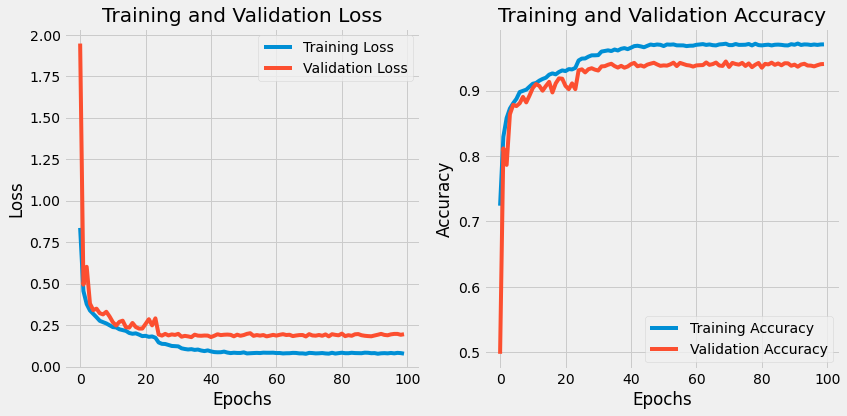

In [ ]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax1.plot(baseline_hist.history['loss'], label='Training Loss')
ax1.plot(baseline_hist.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
# ax1.set_ylim(bottom=0.0, top=1.0)
ax1.legend()

ax2.plot(baseline_hist.history['accuracy'], label='Training Accuracy')
ax2.plot(baseline_hist.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
# ax2.set_ylim(top=1.0, bottom=0.8)
ax2.legend()

plt.show()

In [ ]:
# Evaluating Training and Testing Set
train = vgg.evaluate(x_train, y_train)
test  = vgg.evaluate(x_test, y_test)

# Creating a Logger to store all Evaluation Results
logger = pd.DataFrame(columns=['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])
logger = logger.append(
    pd.Series(
        {
            'Train Loss': train[0],
            'Train Acc' : train[1],
            'Test Loss' : test[0],
            'Test Acc'  : test[1],
            'Test Percentage Error': "{:.2%}".format(1.0 - test[1])
        },
        name='Modified VGG16 w/ Image Augmentation',))
logger

313/313 [==============================] - 2s 6ms/step - loss: 0.1846 - accuracy: 0.9471


,Train Loss,Train Acc,Test Loss,Test Acc,Test Percentage Error
Modified VGG16 w/ Image Augmentation,0.056965,0.980233,0.184628,0.9471,5.29%


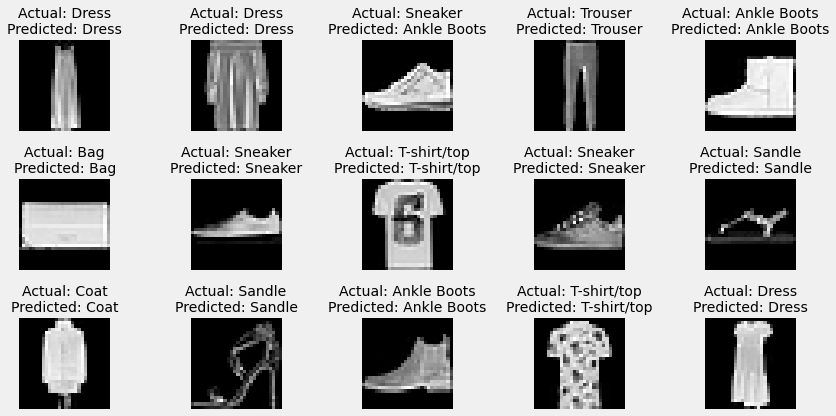

In [ ]:
# Predict the values from the test dataset
y_pred = vgg.predict(x_test)
# Convert predictions classes to one hot encoded vectors 
y_pred_class = np.argmax(y_pred, axis = 1) 

w = 5
h = 3
fig = plt.figure(figsize=(12, 6), tight_layout=True)
for i in range(w*h):
  rand_idx = np.random.randint(0, len(x_test))
  ax = fig.add_subplot(h, w, i+1)
  ax.imshow((x_test[rand_idx]+1)/2)
  ax.axis('off')
  ax.set_title(f'Actual: {classes[y_test[rand_idx]]}\nPredicted: {classes[y_pred_class[rand_idx]]}', fontsize=14)
plt.show()

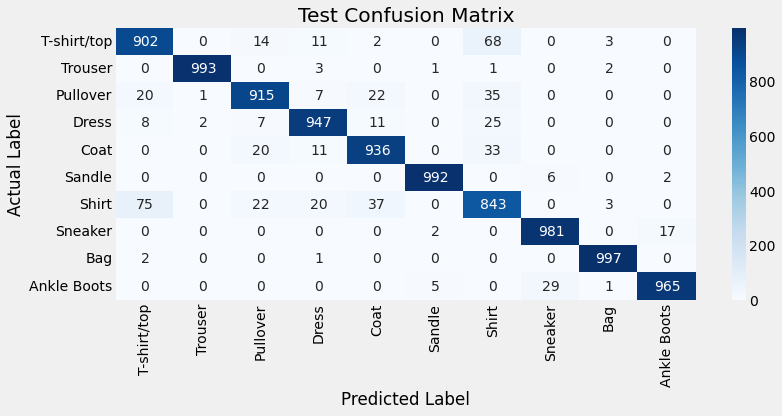

In [ ]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_class)

sns.heatmap(confusion_mtx, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.3g')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
# print out classification report
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.90      0.90      0.90      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.94      0.92      0.93      1000
       Dress       0.95      0.95      0.95      1000
        Coat       0.93      0.94      0.93      1000
      Sandle       0.99      0.99      0.99      1000
       Shirt       0.84      0.84      0.84      1000
     Sneaker       0.97      0.98      0.97      1000
         Bag       0.99      1.00      0.99      1000
 Ankle Boots       0.98      0.96      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



## Observations and Further Improvements

- the Modified VGG Net has performed quite well, setting a high benchmark performance.
- there is some overfitting in the model, however the validation results shows good performance
- One issue within the original VGG architecture was that it has too many layers and parameters, which oftenly leds to Vanishing/Explording gradient issues due to many chain rule operation within backpropagation.

<br>

- for the next step, I want to explore more architectures instead of a regular Sequential type Convolutional Neural Network.
- I would want explore the most common CNN modules available - the Residual Learning module
- The authors of ResNet mentioned that it was inspired by the issues from using the VGG architecture, which led to the invention of the Residual Modules.


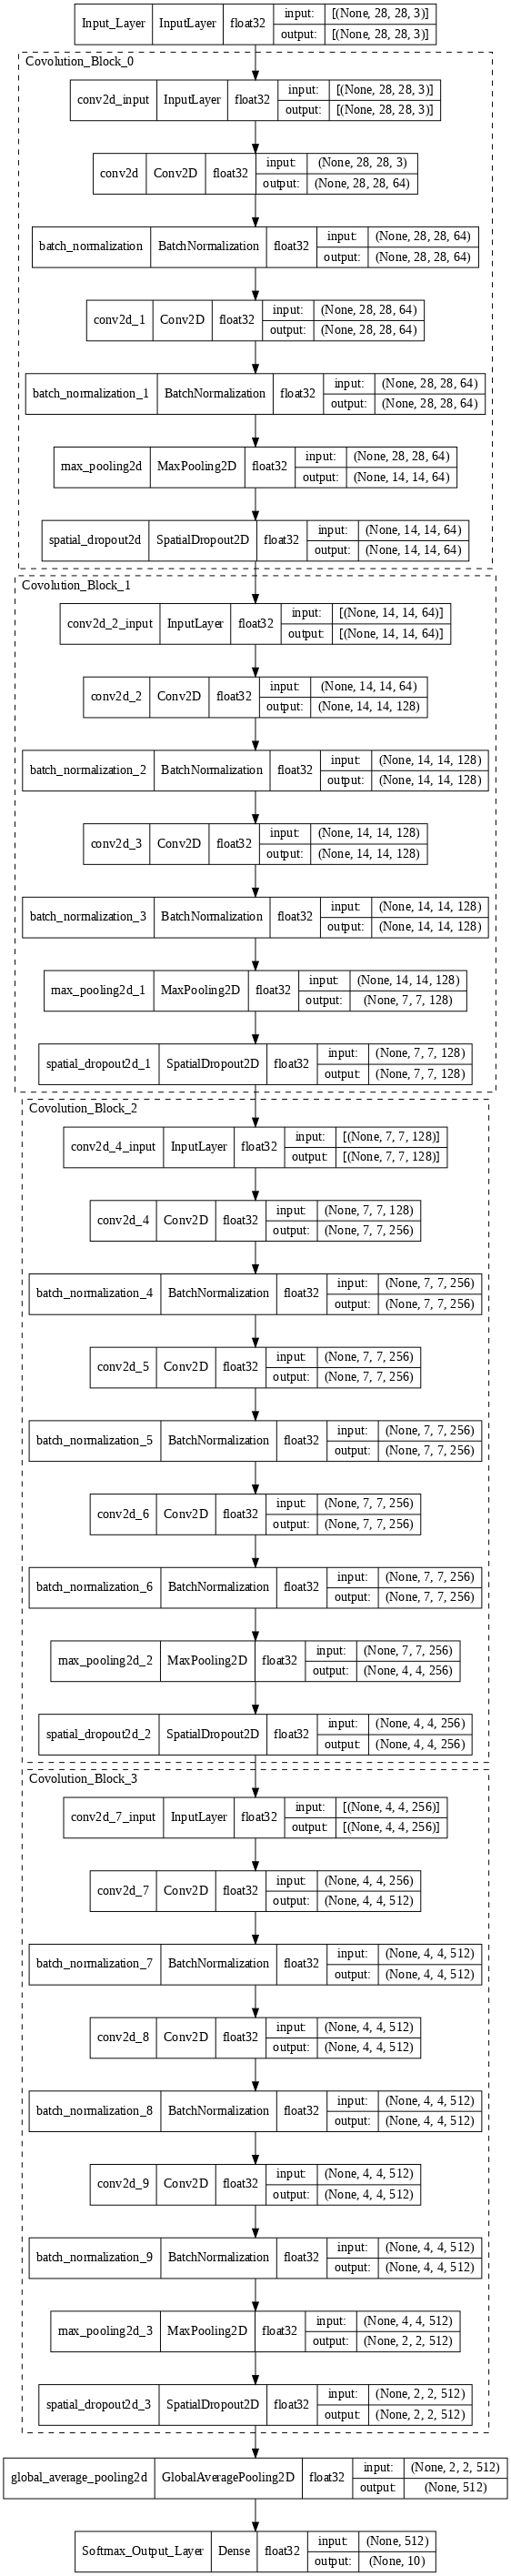

In [ ]:
# Display Model Architecture in Notebook Output
from tensorflow.keras.utils import plot_model
plot_model(vgg, show_shapes=True, show_dtype=True,
    show_layer_names=True, expand_nested=True, dpi=70)